# Dynamic Risk Budgeting between PSP and GHP

Inspired by CPPI, the objective is to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

In [23]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import Basic_Risk_Assessment_Tools as brat

In [3]:
%load_ext autoreload
%autoreload 2

In [9]:
n_scenarios =  5000
rates, zc_prices = brat.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_equity = brat.geo_brown_motion(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15, steps_per_year=12)
returns_equity = price_equity.pct_change().dropna()
returns_zc = zc_prices.pct_change().dropna()
portfolio_returns_7030z = brat.bt_mix(returns_equity, returns_zc, allocator=brat.fixedmix_allocator, w1=0.7)
pd.concat([brat.terminal_stats(returns_equity, name="Equity", floor=0.75),
           brat.terminal_stats(returns_zc, name="Zero Coupon Bonds", floor=0.75),
           brat.terminal_stats(portfolio_returns_7030z, name="Naive 70/30 Zero Coupon", floor=0.75)],
          axis=1)

,Equity,Zero Coupon Bonds,Naive 70/30 Zero Coupon
mean,2.00583,1.34334,1.77964
std,1.00616,1.31782e-13,0.602727
breach_count,143,0,34
reach_count,143,0,34
p_breach,0.0286,N/A,0.0068
e_short,0.12176,N/A,0.0768826
p_reach,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A


The allocators that we worked on aren't great at preventing us from breaching the floor. That is mostly because the allocators that we've used till now assign weights without looking into the floor value and the current investment value.

We can now try to build a CPPI based allocator that is cognizant of the Floor and Investment Value when choosing how to allocate its resources.

In [6]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)     #initialize account value
    floor_value = np.repeat(1, n_scenarios)       #initialize floor value
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)     #create empty weights log over time
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # clip keeps the weight between 0 and 1
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [10]:
portfolio_returns_floor75 = brat.bt_mix(returns_equity, returns_zc, allocator=brat.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([brat.terminal_stats(returns_equity, name="Equity", floor=0.75),
           brat.terminal_stats(returns_zc, name="Zero Coupon Bonds", floor=0.75),
           brat.terminal_stats(portfolio_returns_7030z, name="Naive 70/30 Zero Coupon", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75, name="Floor Allocator", floor=0.75)],
          axis=1)

,Equity,Zero Coupon Bonds,Naive 70/30 Zero Coupon,Floor Allocator
mean,2.00583,1.34334,1.77964,1.98147
std,1.00616,1.31782e-13,0.602727,1.01426
breach_count,143,0,34,0
reach_count,143,0,34,0
p_breach,0.0286,N/A,0.0068,N/A
e_short,0.12176,N/A,0.0768826,N/A
p_reach,N/A,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A,N/A


In [11]:
portfolio_returns_floor75m1 = brat.bt_mix(returns_equity, returns_zc, allocator=brat.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
portfolio_returns_floor75m6 = brat.bt_mix(returns_equity, returns_zc, allocator=brat.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=6)
pd.concat([brat.terminal_stats(returns_equity, name="Equity", floor=0.75),
           brat.terminal_stats(returns_zc, name="Zero Coupon Bonds", floor=0.75),
           brat.terminal_stats(portfolio_returns_7030z, name="Naive 70/30 Zero Coupon", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75m1, name="Floor Allocator m=1", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75, name="Floor Allocator m=3", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75m6, name="Floor Allocator m=6", floor=0.75)],
          axis=1)

,Equity,Zero Coupon Bonds,Naive 70/30 Zero Coupon,Floor Allocator m=1,Floor Allocator m=3,Floor Allocator m=6
mean,2.00583,1.34334,1.77964,1.63778,1.98147,1.99314
std,1.00616,1.31782e-13,0.602727,0.443972,1.01426,1.01517
breach_count,143,0,34,0,0,1
reach_count,143,0,34,0,0,1
p_breach,0.0286,N/A,0.0068,N/A,N/A,0.0002
e_short,0.12176,N/A,0.0768826,N/A,N/A,0.000217127
p_reach,N/A,N/A,N/A,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A,N/A,N/A,N/A


We can see the benefits of a CPPI Based `floor_allocator`.

Even in a very high risk taking mindset with m=6 we breach the floor only once and even in that scenaro the Shortfall is negligible. The return in this scenario is also almost as good as an 100% Equity Investment but with none of the downside.

## Dynamic Risk Budgeting with Drawdown instead of a fixed floor

Similar to the $Drawdown Constraint$ that we added in the CPPI Model, we can add a similar feature to the CPPI Based `floor_allocator` that enable us to make the floor dynamic and prevent unrewarded losses. 

In [13]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)     #initialize account value
    floor_value = np.repeat(1, n_scenarios)       #initialize floor value
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history

In the case of the `drawdown_allocator` we cannot use Coupon or Zero Coupon Bonds as the safe asset because the price of these bonds do fluctuate through their maturity period and they themselves have a drawdown value.

Therefore, we can use $Cash$ as the Safe or Risk Free Asset for the LHP.

In [26]:
cashrate = 0.02    # Interest Rate on cash kept in account
monthly_cashreturn = (1+cashrate)**(1/12) - 1   # Monthly return on cash assuming compounding
returns_cash = pd.DataFrame(data= monthly_cashreturn, index=returns_equity.index, columns=returns_equity.columns)
portfolio_returns_ddm1 = brat.bt_mix(returns_equity, returns_cash, allocator=brat.drawdown_allocator, maxdd=0.25, m=1)
portfolio_returns_ddm3 = brat.bt_mix(returns_equity, returns_cash, allocator=brat.drawdown_allocator, maxdd=0.25, m=3)
portfolio_returns_ddm6 = brat.bt_mix(returns_equity, returns_cash, allocator=brat.drawdown_allocator, maxdd=0.25, m=6)
pd.concat([brat.terminal_stats(returns_equity, name="Equity", floor=0.75),
           brat.terminal_stats(returns_zc, name="Zero Coupon Bonds", floor=0.75),
           brat.terminal_stats(portfolio_returns_7030z, name="Naive 70/30 Zero Coupon", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75m1, name="Floor Allocator m=1", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75, name="Floor Allocator m=3", floor=0.75),
           brat.terminal_stats(portfolio_returns_floor75m6, name="Floor Allocator m=6", floor=0.75),
           brat.terminal_stats(portfolio_returns_ddm1, name="DD Allocator m=1", floor=0.75),
           brat.terminal_stats(portfolio_returns_ddm3, name="DD Allocator m=3", floor=0.75),
           brat.terminal_stats(portfolio_returns_ddm6, name="DD Allocator m=6", floor=0.75)],
          axis=1)

,Equity,Zero Coupon Bonds,Naive 70/30 Zero Coupon,Floor Allocator m=1,Floor Allocator m=3,Floor Allocator m=6,DD Allocator m=1,DD Allocator m=3,DD Allocator m=6
mean,2.00583,1.34334,1.77964,1.63778,1.98147,1.99314,1.374,1.64772,1.83121
std,1.00616,1.31782e-13,0.602727,0.443972,1.01426,1.01517,0.158068,0.552847,0.92772
breach_count,143,0,34,0,0,1,0,0,0
reach_count,143,0,34,0,0,1,0,0,0
p_breach,0.0286,N/A,0.0068,N/A,N/A,0.0002,N/A,N/A,N/A
e_short,0.12176,N/A,0.0768826,N/A,N/A,0.000217127,N/A,N/A,N/A
p_reach,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


We can see that the `drawdown_allocator` has helped eliminate the floor breaches but the returns aren't as high as those of the floor allocator.

However, the main reason we did this was to prevent a loss, greater than 25% of the peak value, in the account value. Let us check if we were successful in doing that.

In [27]:
portfolio_returns_dd_dict = {}
for header in list(portfolio_returns_ddm3.columns):
    portfolio_returns_dd_dict[header] = pd.DataFrame(data=portfolio_returns_ddm3[header], columns=[header])

In [28]:
brat.summary_stats(portfolio_returns_dd_dict, annualizing_factor=12, risk_free_return=0.03)["Max Drawdown in %"].min()

-23.641945289596798

This shows that we have managed to limit the Maximum Drawdown across all 5000 scenarios to a value of 23.6%, which is less than our target 25%.

In [21]:
tv_eq = brat.terminal_values(returns_equity)
tv_7030z = brat.terminal_values(portfolio_returns_7030z)
tv_floor75 = brat.terminal_values(portfolio_returns_floor75m6)
tv_maxdd25 = brat.terminal_values(portfolio_returns_ddm6)

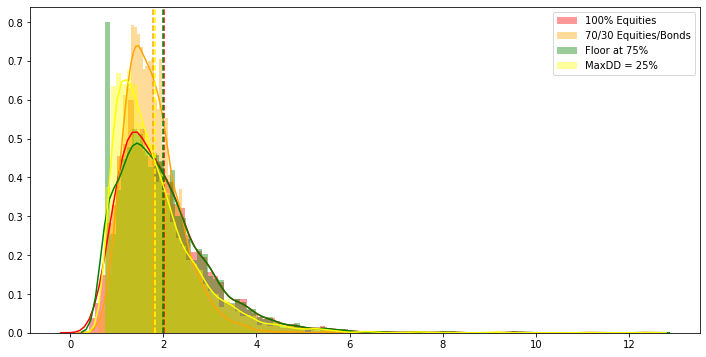

In [25]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030z, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030z.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();